# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [4]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


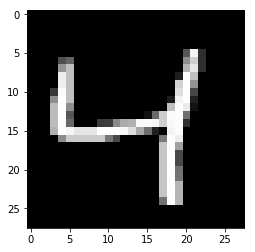

In [6]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [29]:
learning_rate = 0.001

image_size = mnist.train.images.shape[1]
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32,(None, 28, 28, 1), name="inputs")
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name="targets")

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2))
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2))
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2))
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding="same", activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name="output")

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [30]:
sess = tf.Session()

In [31]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6884
Epoch: 1/20... Training loss: 0.6810
Epoch: 1/20... Training loss: 0.6727
Epoch: 1/20... Training loss: 0.6636
Epoch: 1/20... Training loss: 0.6517
Epoch: 1/20... Training loss: 0.6391
Epoch: 1/20... Training loss: 0.6204
Epoch: 1/20... Training loss: 0.6038
Epoch: 1/20... Training loss: 0.5855
Epoch: 1/20... Training loss: 0.5640
Epoch: 1/20... Training loss: 0.5456
Epoch: 1/20... Training loss: 0.5463
Epoch: 1/20... Training loss: 0.5323
Epoch: 1/20... Training loss: 0.5423
Epoch: 1/20... Training loss: 0.5309
Epoch: 1/20... Training loss: 0.5183
Epoch: 1/20... Training loss: 0.5191
Epoch: 1/20... Training loss: 0.5152
Epoch: 1/20... Training loss: 0.5077
Epoch: 1/20... Training loss: 0.4916
Epoch: 1/20... Training loss: 0.5041
Epoch: 1/20... Training loss: 0.4897
Epoch: 1/20... Training loss: 0.4818
Epoch: 1/20... Training loss: 0.4853
Epoch: 1/20... Training loss: 0.4743
Epoch: 1/20... Training loss: 0.4730
Epoch: 1/20... Training loss: 0.4613
E

Epoch: 1/20... Training loss: 0.1792
Epoch: 1/20... Training loss: 0.1754
Epoch: 1/20... Training loss: 0.1853
Epoch: 1/20... Training loss: 0.1759
Epoch: 1/20... Training loss: 0.1751
Epoch: 1/20... Training loss: 0.1789
Epoch: 1/20... Training loss: 0.1811
Epoch: 1/20... Training loss: 0.1872
Epoch: 1/20... Training loss: 0.1815
Epoch: 1/20... Training loss: 0.1819
Epoch: 1/20... Training loss: 0.1816
Epoch: 1/20... Training loss: 0.1830
Epoch: 1/20... Training loss: 0.1812
Epoch: 1/20... Training loss: 0.1780
Epoch: 1/20... Training loss: 0.1796
Epoch: 1/20... Training loss: 0.1784
Epoch: 1/20... Training loss: 0.1706
Epoch: 1/20... Training loss: 0.1779
Epoch: 1/20... Training loss: 0.1825
Epoch: 1/20... Training loss: 0.1768
Epoch: 1/20... Training loss: 0.1792
Epoch: 1/20... Training loss: 0.1774
Epoch: 1/20... Training loss: 0.1801
Epoch: 1/20... Training loss: 0.1724
Epoch: 1/20... Training loss: 0.1789
Epoch: 1/20... Training loss: 0.1770
Epoch: 1/20... Training loss: 0.1691
E

Epoch: 2/20... Training loss: 0.1700
Epoch: 2/20... Training loss: 0.1558
Epoch: 2/20... Training loss: 0.1587
Epoch: 2/20... Training loss: 0.1653
Epoch: 2/20... Training loss: 0.1575
Epoch: 2/20... Training loss: 0.1688
Epoch: 2/20... Training loss: 0.1615
Epoch: 2/20... Training loss: 0.1587
Epoch: 2/20... Training loss: 0.1611
Epoch: 2/20... Training loss: 0.1651
Epoch: 2/20... Training loss: 0.1594
Epoch: 2/20... Training loss: 0.1623
Epoch: 2/20... Training loss: 0.1574
Epoch: 2/20... Training loss: 0.1597
Epoch: 2/20... Training loss: 0.1635
Epoch: 2/20... Training loss: 0.1636
Epoch: 2/20... Training loss: 0.1648
Epoch: 2/20... Training loss: 0.1571
Epoch: 2/20... Training loss: 0.1566
Epoch: 2/20... Training loss: 0.1533
Epoch: 2/20... Training loss: 0.1599
Epoch: 2/20... Training loss: 0.1591
Epoch: 2/20... Training loss: 0.1545
Epoch: 2/20... Training loss: 0.1606
Epoch: 2/20... Training loss: 0.1571
Epoch: 2/20... Training loss: 0.1645
Epoch: 2/20... Training loss: 0.1644
E

Epoch: 3/20... Training loss: 0.1487
Epoch: 3/20... Training loss: 0.1472
Epoch: 3/20... Training loss: 0.1505
Epoch: 3/20... Training loss: 0.1517
Epoch: 3/20... Training loss: 0.1536
Epoch: 3/20... Training loss: 0.1467
Epoch: 3/20... Training loss: 0.1562
Epoch: 3/20... Training loss: 0.1467
Epoch: 3/20... Training loss: 0.1527
Epoch: 3/20... Training loss: 0.1560
Epoch: 3/20... Training loss: 0.1481
Epoch: 3/20... Training loss: 0.1510
Epoch: 3/20... Training loss: 0.1586
Epoch: 3/20... Training loss: 0.1536
Epoch: 3/20... Training loss: 0.1547
Epoch: 3/20... Training loss: 0.1533
Epoch: 3/20... Training loss: 0.1451
Epoch: 3/20... Training loss: 0.1535
Epoch: 3/20... Training loss: 0.1545
Epoch: 3/20... Training loss: 0.1494
Epoch: 3/20... Training loss: 0.1509
Epoch: 3/20... Training loss: 0.1548
Epoch: 3/20... Training loss: 0.1466
Epoch: 3/20... Training loss: 0.1508
Epoch: 3/20... Training loss: 0.1477
Epoch: 3/20... Training loss: 0.1493
Epoch: 3/20... Training loss: 0.1538
E

Epoch: 3/20... Training loss: 0.1505
Epoch: 3/20... Training loss: 0.1408
Epoch: 3/20... Training loss: 0.1416
Epoch: 3/20... Training loss: 0.1470
Epoch: 3/20... Training loss: 0.1453
Epoch: 3/20... Training loss: 0.1435
Epoch: 3/20... Training loss: 0.1451
Epoch: 3/20... Training loss: 0.1418
Epoch: 3/20... Training loss: 0.1463
Epoch: 3/20... Training loss: 0.1432
Epoch: 3/20... Training loss: 0.1441
Epoch: 3/20... Training loss: 0.1396
Epoch: 4/20... Training loss: 0.1443
Epoch: 4/20... Training loss: 0.1416
Epoch: 4/20... Training loss: 0.1445
Epoch: 4/20... Training loss: 0.1471
Epoch: 4/20... Training loss: 0.1472
Epoch: 4/20... Training loss: 0.1441
Epoch: 4/20... Training loss: 0.1435
Epoch: 4/20... Training loss: 0.1461
Epoch: 4/20... Training loss: 0.1420
Epoch: 4/20... Training loss: 0.1332
Epoch: 4/20... Training loss: 0.1442
Epoch: 4/20... Training loss: 0.1407
Epoch: 4/20... Training loss: 0.1426
Epoch: 4/20... Training loss: 0.1419
Epoch: 4/20... Training loss: 0.1406
E

Epoch: 4/20... Training loss: 0.1436
Epoch: 4/20... Training loss: 0.1377
Epoch: 4/20... Training loss: 0.1437
Epoch: 4/20... Training loss: 0.1378
Epoch: 4/20... Training loss: 0.1308
Epoch: 4/20... Training loss: 0.1442
Epoch: 4/20... Training loss: 0.1449
Epoch: 4/20... Training loss: 0.1408
Epoch: 4/20... Training loss: 0.1379
Epoch: 4/20... Training loss: 0.1355
Epoch: 4/20... Training loss: 0.1352
Epoch: 4/20... Training loss: 0.1387
Epoch: 4/20... Training loss: 0.1408
Epoch: 4/20... Training loss: 0.1404
Epoch: 4/20... Training loss: 0.1353
Epoch: 4/20... Training loss: 0.1421
Epoch: 4/20... Training loss: 0.1428
Epoch: 4/20... Training loss: 0.1402
Epoch: 4/20... Training loss: 0.1357
Epoch: 4/20... Training loss: 0.1387
Epoch: 4/20... Training loss: 0.1400
Epoch: 4/20... Training loss: 0.1411
Epoch: 4/20... Training loss: 0.1388
Epoch: 4/20... Training loss: 0.1395
Epoch: 4/20... Training loss: 0.1394
Epoch: 4/20... Training loss: 0.1394
Epoch: 4/20... Training loss: 0.1368
E

Epoch: 5/20... Training loss: 0.1382
Epoch: 5/20... Training loss: 0.1357
Epoch: 5/20... Training loss: 0.1313
Epoch: 5/20... Training loss: 0.1339
Epoch: 5/20... Training loss: 0.1331
Epoch: 5/20... Training loss: 0.1415
Epoch: 5/20... Training loss: 0.1344
Epoch: 5/20... Training loss: 0.1336
Epoch: 5/20... Training loss: 0.1383
Epoch: 5/20... Training loss: 0.1318
Epoch: 5/20... Training loss: 0.1314
Epoch: 5/20... Training loss: 0.1312
Epoch: 5/20... Training loss: 0.1371
Epoch: 5/20... Training loss: 0.1341
Epoch: 5/20... Training loss: 0.1353
Epoch: 5/20... Training loss: 0.1360
Epoch: 5/20... Training loss: 0.1288
Epoch: 5/20... Training loss: 0.1291
Epoch: 5/20... Training loss: 0.1364
Epoch: 5/20... Training loss: 0.1340
Epoch: 5/20... Training loss: 0.1314
Epoch: 5/20... Training loss: 0.1352
Epoch: 5/20... Training loss: 0.1347
Epoch: 5/20... Training loss: 0.1358
Epoch: 5/20... Training loss: 0.1364
Epoch: 5/20... Training loss: 0.1386
Epoch: 5/20... Training loss: 0.1351
E

Epoch: 6/20... Training loss: 0.1345
Epoch: 6/20... Training loss: 0.1355
Epoch: 6/20... Training loss: 0.1323
Epoch: 6/20... Training loss: 0.1303
Epoch: 6/20... Training loss: 0.1333
Epoch: 6/20... Training loss: 0.1348
Epoch: 6/20... Training loss: 0.1280
Epoch: 6/20... Training loss: 0.1251
Epoch: 6/20... Training loss: 0.1351
Epoch: 6/20... Training loss: 0.1308
Epoch: 6/20... Training loss: 0.1317
Epoch: 6/20... Training loss: 0.1311
Epoch: 6/20... Training loss: 0.1264
Epoch: 6/20... Training loss: 0.1329
Epoch: 6/20... Training loss: 0.1297
Epoch: 6/20... Training loss: 0.1283
Epoch: 6/20... Training loss: 0.1316
Epoch: 6/20... Training loss: 0.1319
Epoch: 6/20... Training loss: 0.1318
Epoch: 6/20... Training loss: 0.1351
Epoch: 6/20... Training loss: 0.1350
Epoch: 6/20... Training loss: 0.1292
Epoch: 6/20... Training loss: 0.1352
Epoch: 6/20... Training loss: 0.1343
Epoch: 6/20... Training loss: 0.1313
Epoch: 6/20... Training loss: 0.1355
Epoch: 6/20... Training loss: 0.1341
E

Epoch: 6/20... Training loss: 0.1260
Epoch: 6/20... Training loss: 0.1288
Epoch: 6/20... Training loss: 0.1273
Epoch: 6/20... Training loss: 0.1258
Epoch: 6/20... Training loss: 0.1316
Epoch: 6/20... Training loss: 0.1346
Epoch: 6/20... Training loss: 0.1287
Epoch: 6/20... Training loss: 0.1260
Epoch: 6/20... Training loss: 0.1292
Epoch: 6/20... Training loss: 0.1251
Epoch: 6/20... Training loss: 0.1270
Epoch: 6/20... Training loss: 0.1312
Epoch: 6/20... Training loss: 0.1281
Epoch: 6/20... Training loss: 0.1275
Epoch: 6/20... Training loss: 0.1324
Epoch: 6/20... Training loss: 0.1298
Epoch: 6/20... Training loss: 0.1191
Epoch: 6/20... Training loss: 0.1267
Epoch: 6/20... Training loss: 0.1268
Epoch: 6/20... Training loss: 0.1246
Epoch: 6/20... Training loss: 0.1293
Epoch: 6/20... Training loss: 0.1299
Epoch: 6/20... Training loss: 0.1308
Epoch: 6/20... Training loss: 0.1279
Epoch: 7/20... Training loss: 0.1294
Epoch: 7/20... Training loss: 0.1305
Epoch: 7/20... Training loss: 0.1309
E

Epoch: 7/20... Training loss: 0.1214
Epoch: 7/20... Training loss: 0.1276
Epoch: 7/20... Training loss: 0.1266
Epoch: 7/20... Training loss: 0.1223
Epoch: 7/20... Training loss: 0.1259
Epoch: 7/20... Training loss: 0.1229
Epoch: 7/20... Training loss: 0.1275
Epoch: 7/20... Training loss: 0.1229
Epoch: 7/20... Training loss: 0.1279
Epoch: 7/20... Training loss: 0.1230
Epoch: 7/20... Training loss: 0.1220
Epoch: 7/20... Training loss: 0.1229
Epoch: 7/20... Training loss: 0.1293
Epoch: 7/20... Training loss: 0.1246
Epoch: 7/20... Training loss: 0.1265
Epoch: 7/20... Training loss: 0.1293
Epoch: 7/20... Training loss: 0.1220
Epoch: 7/20... Training loss: 0.1237
Epoch: 7/20... Training loss: 0.1288
Epoch: 7/20... Training loss: 0.1257
Epoch: 7/20... Training loss: 0.1228
Epoch: 7/20... Training loss: 0.1347
Epoch: 7/20... Training loss: 0.1328
Epoch: 7/20... Training loss: 0.1293
Epoch: 7/20... Training loss: 0.1269
Epoch: 7/20... Training loss: 0.1221
Epoch: 7/20... Training loss: 0.1264
E

Epoch: 8/20... Training loss: 0.1254
Epoch: 8/20... Training loss: 0.1243
Epoch: 8/20... Training loss: 0.1200
Epoch: 8/20... Training loss: 0.1225
Epoch: 8/20... Training loss: 0.1251
Epoch: 8/20... Training loss: 0.1222
Epoch: 8/20... Training loss: 0.1209
Epoch: 8/20... Training loss: 0.1220
Epoch: 8/20... Training loss: 0.1255
Epoch: 8/20... Training loss: 0.1211
Epoch: 8/20... Training loss: 0.1248
Epoch: 8/20... Training loss: 0.1215
Epoch: 8/20... Training loss: 0.1239
Epoch: 8/20... Training loss: 0.1201
Epoch: 8/20... Training loss: 0.1248
Epoch: 8/20... Training loss: 0.1220
Epoch: 8/20... Training loss: 0.1216
Epoch: 8/20... Training loss: 0.1231
Epoch: 8/20... Training loss: 0.1254
Epoch: 8/20... Training loss: 0.1265
Epoch: 8/20... Training loss: 0.1247
Epoch: 8/20... Training loss: 0.1293
Epoch: 8/20... Training loss: 0.1279
Epoch: 8/20... Training loss: 0.1250
Epoch: 8/20... Training loss: 0.1219
Epoch: 8/20... Training loss: 0.1218
Epoch: 8/20... Training loss: 0.1229
E

Epoch: 9/20... Training loss: 0.1187
Epoch: 9/20... Training loss: 0.1170
Epoch: 9/20... Training loss: 0.1186
Epoch: 9/20... Training loss: 0.1208
Epoch: 9/20... Training loss: 0.1248
Epoch: 9/20... Training loss: 0.1191
Epoch: 9/20... Training loss: 0.1236
Epoch: 9/20... Training loss: 0.1201
Epoch: 9/20... Training loss: 0.1252
Epoch: 9/20... Training loss: 0.1273
Epoch: 9/20... Training loss: 0.1198
Epoch: 9/20... Training loss: 0.1254
Epoch: 9/20... Training loss: 0.1239
Epoch: 9/20... Training loss: 0.1228
Epoch: 9/20... Training loss: 0.1228
Epoch: 9/20... Training loss: 0.1230
Epoch: 9/20... Training loss: 0.1233
Epoch: 9/20... Training loss: 0.1182
Epoch: 9/20... Training loss: 0.1215
Epoch: 9/20... Training loss: 0.1238
Epoch: 9/20... Training loss: 0.1222
Epoch: 9/20... Training loss: 0.1217
Epoch: 9/20... Training loss: 0.1200
Epoch: 9/20... Training loss: 0.1206
Epoch: 9/20... Training loss: 0.1281
Epoch: 9/20... Training loss: 0.1241
Epoch: 9/20... Training loss: 0.1272
E

Epoch: 9/20... Training loss: 0.1202
Epoch: 9/20... Training loss: 0.1226
Epoch: 9/20... Training loss: 0.1186
Epoch: 9/20... Training loss: 0.1196
Epoch: 9/20... Training loss: 0.1192
Epoch: 9/20... Training loss: 0.1222
Epoch: 9/20... Training loss: 0.1163
Epoch: 9/20... Training loss: 0.1183
Epoch: 9/20... Training loss: 0.1139
Epoch: 9/20... Training loss: 0.1242
Epoch: 9/20... Training loss: 0.1216
Epoch: 9/20... Training loss: 0.1217
Epoch: 9/20... Training loss: 0.1222
Epoch: 9/20... Training loss: 0.1231
Epoch: 9/20... Training loss: 0.1191
Epoch: 9/20... Training loss: 0.1227
Epoch: 9/20... Training loss: 0.1208
Epoch: 9/20... Training loss: 0.1230
Epoch: 9/20... Training loss: 0.1259
Epoch: 9/20... Training loss: 0.1219
Epoch: 9/20... Training loss: 0.1273
Epoch: 9/20... Training loss: 0.1251
Epoch: 9/20... Training loss: 0.1288
Epoch: 9/20... Training loss: 0.1215
Epoch: 9/20... Training loss: 0.1226
Epoch: 9/20... Training loss: 0.1199
Epoch: 9/20... Training loss: 0.1173
E

Epoch: 10/20... Training loss: 0.1173
Epoch: 10/20... Training loss: 0.1184
Epoch: 10/20... Training loss: 0.1207
Epoch: 10/20... Training loss: 0.1202
Epoch: 10/20... Training loss: 0.1207
Epoch: 10/20... Training loss: 0.1211
Epoch: 10/20... Training loss: 0.1198
Epoch: 10/20... Training loss: 0.1236
Epoch: 10/20... Training loss: 0.1191
Epoch: 10/20... Training loss: 0.1185
Epoch: 10/20... Training loss: 0.1151
Epoch: 10/20... Training loss: 0.1183
Epoch: 10/20... Training loss: 0.1190
Epoch: 10/20... Training loss: 0.1187
Epoch: 10/20... Training loss: 0.1176
Epoch: 10/20... Training loss: 0.1216
Epoch: 10/20... Training loss: 0.1169
Epoch: 10/20... Training loss: 0.1196
Epoch: 10/20... Training loss: 0.1182
Epoch: 10/20... Training loss: 0.1165
Epoch: 10/20... Training loss: 0.1165
Epoch: 10/20... Training loss: 0.1197
Epoch: 10/20... Training loss: 0.1176
Epoch: 10/20... Training loss: 0.1176
Epoch: 10/20... Training loss: 0.1187
Epoch: 10/20... Training loss: 0.1215
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1193
Epoch: 11/20... Training loss: 0.1204
Epoch: 11/20... Training loss: 0.1214
Epoch: 11/20... Training loss: 0.1203
Epoch: 11/20... Training loss: 0.1208
Epoch: 11/20... Training loss: 0.1204
Epoch: 11/20... Training loss: 0.1139
Epoch: 11/20... Training loss: 0.1204
Epoch: 11/20... Training loss: 0.1189
Epoch: 11/20... Training loss: 0.1183
Epoch: 11/20... Training loss: 0.1180
Epoch: 11/20... Training loss: 0.1202
Epoch: 11/20... Training loss: 0.1174
Epoch: 11/20... Training loss: 0.1172
Epoch: 11/20... Training loss: 0.1162
Epoch: 11/20... Training loss: 0.1162
Epoch: 11/20... Training loss: 0.1180
Epoch: 11/20... Training loss: 0.1212
Epoch: 11/20... Training loss: 0.1203
Epoch: 11/20... Training loss: 0.1167
Epoch: 11/20... Training loss: 0.1225
Epoch: 11/20... Training loss: 0.1210
Epoch: 11/20... Training loss: 0.1187
Epoch: 11/20... Training loss: 0.1162
Epoch: 11/20... Training loss: 0.1192
Epoch: 11/20... Training loss: 0.1133
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1115
Epoch: 12/20... Training loss: 0.1174
Epoch: 12/20... Training loss: 0.1191
Epoch: 12/20... Training loss: 0.1191
Epoch: 12/20... Training loss: 0.1184
Epoch: 12/20... Training loss: 0.1183
Epoch: 12/20... Training loss: 0.1201
Epoch: 12/20... Training loss: 0.1181
Epoch: 12/20... Training loss: 0.1140
Epoch: 12/20... Training loss: 0.1184
Epoch: 12/20... Training loss: 0.1187
Epoch: 12/20... Training loss: 0.1198
Epoch: 12/20... Training loss: 0.1181
Epoch: 12/20... Training loss: 0.1163
Epoch: 12/20... Training loss: 0.1153
Epoch: 12/20... Training loss: 0.1178
Epoch: 12/20... Training loss: 0.1157
Epoch: 12/20... Training loss: 0.1171
Epoch: 12/20... Training loss: 0.1156
Epoch: 12/20... Training loss: 0.1189
Epoch: 12/20... Training loss: 0.1172
Epoch: 12/20... Training loss: 0.1229
Epoch: 12/20... Training loss: 0.1194
Epoch: 12/20... Training loss: 0.1167
Epoch: 12/20... Training loss: 0.1126
Epoch: 12/20... Training loss: 0.1192
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1155
Epoch: 12/20... Training loss: 0.1123
Epoch: 12/20... Training loss: 0.1187
Epoch: 12/20... Training loss: 0.1204
Epoch: 12/20... Training loss: 0.1144
Epoch: 12/20... Training loss: 0.1176
Epoch: 12/20... Training loss: 0.1169
Epoch: 12/20... Training loss: 0.1156
Epoch: 12/20... Training loss: 0.1156
Epoch: 12/20... Training loss: 0.1162
Epoch: 12/20... Training loss: 0.1120
Epoch: 12/20... Training loss: 0.1148
Epoch: 12/20... Training loss: 0.1160
Epoch: 12/20... Training loss: 0.1153
Epoch: 12/20... Training loss: 0.1149
Epoch: 12/20... Training loss: 0.1198
Epoch: 12/20... Training loss: 0.1233
Epoch: 12/20... Training loss: 0.1230
Epoch: 12/20... Training loss: 0.1142
Epoch: 12/20... Training loss: 0.1218
Epoch: 12/20... Training loss: 0.1154
Epoch: 12/20... Training loss: 0.1146
Epoch: 12/20... Training loss: 0.1152
Epoch: 12/20... Training loss: 0.1140
Epoch: 12/20... Training loss: 0.1128
Epoch: 12/20... Training loss: 0.1162
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1153
Epoch: 13/20... Training loss: 0.1184
Epoch: 13/20... Training loss: 0.1113
Epoch: 13/20... Training loss: 0.1127
Epoch: 13/20... Training loss: 0.1149
Epoch: 13/20... Training loss: 0.1179
Epoch: 13/20... Training loss: 0.1183
Epoch: 13/20... Training loss: 0.1184
Epoch: 13/20... Training loss: 0.1157
Epoch: 13/20... Training loss: 0.1168
Epoch: 13/20... Training loss: 0.1129
Epoch: 13/20... Training loss: 0.1120
Epoch: 13/20... Training loss: 0.1194
Epoch: 13/20... Training loss: 0.1123
Epoch: 13/20... Training loss: 0.1170
Epoch: 13/20... Training loss: 0.1121
Epoch: 13/20... Training loss: 0.1197
Epoch: 13/20... Training loss: 0.1167
Epoch: 13/20... Training loss: 0.1159
Epoch: 13/20... Training loss: 0.1212
Epoch: 13/20... Training loss: 0.1132
Epoch: 13/20... Training loss: 0.1150
Epoch: 13/20... Training loss: 0.1142
Epoch: 13/20... Training loss: 0.1157
Epoch: 13/20... Training loss: 0.1144
Epoch: 13/20... Training loss: 0.1129
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1165
Epoch: 14/20... Training loss: 0.1139
Epoch: 14/20... Training loss: 0.1149
Epoch: 14/20... Training loss: 0.1163
Epoch: 14/20... Training loss: 0.1135
Epoch: 14/20... Training loss: 0.1154
Epoch: 14/20... Training loss: 0.1151
Epoch: 14/20... Training loss: 0.1124
Epoch: 14/20... Training loss: 0.1177
Epoch: 14/20... Training loss: 0.1121
Epoch: 14/20... Training loss: 0.1101
Epoch: 14/20... Training loss: 0.1147
Epoch: 14/20... Training loss: 0.1191
Epoch: 14/20... Training loss: 0.1135
Epoch: 14/20... Training loss: 0.1090
Epoch: 14/20... Training loss: 0.1136
Epoch: 14/20... Training loss: 0.1144
Epoch: 14/20... Training loss: 0.1125
Epoch: 14/20... Training loss: 0.1182
Epoch: 14/20... Training loss: 0.1173
Epoch: 14/20... Training loss: 0.1146
Epoch: 14/20... Training loss: 0.1163
Epoch: 14/20... Training loss: 0.1177
Epoch: 14/20... Training loss: 0.1144
Epoch: 14/20... Training loss: 0.1141
Epoch: 14/20... Training loss: 0.1173
Epoch: 14/20

Epoch: 14/20... Training loss: 0.1149
Epoch: 14/20... Training loss: 0.1136
Epoch: 14/20... Training loss: 0.1167
Epoch: 14/20... Training loss: 0.1150
Epoch: 14/20... Training loss: 0.1181
Epoch: 14/20... Training loss: 0.1135
Epoch: 14/20... Training loss: 0.1173
Epoch: 14/20... Training loss: 0.1141
Epoch: 14/20... Training loss: 0.1147
Epoch: 14/20... Training loss: 0.1186
Epoch: 14/20... Training loss: 0.1118
Epoch: 14/20... Training loss: 0.1155
Epoch: 14/20... Training loss: 0.1069
Epoch: 14/20... Training loss: 0.1145
Epoch: 14/20... Training loss: 0.1097
Epoch: 14/20... Training loss: 0.1109
Epoch: 14/20... Training loss: 0.1160
Epoch: 14/20... Training loss: 0.1137
Epoch: 14/20... Training loss: 0.1156
Epoch: 14/20... Training loss: 0.1163
Epoch: 14/20... Training loss: 0.1114
Epoch: 14/20... Training loss: 0.1173
Epoch: 14/20... Training loss: 0.1129
Epoch: 15/20... Training loss: 0.1186
Epoch: 15/20... Training loss: 0.1140
Epoch: 15/20... Training loss: 0.1177
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1095
Epoch: 15/20... Training loss: 0.1143
Epoch: 15/20... Training loss: 0.1146
Epoch: 15/20... Training loss: 0.1123
Epoch: 15/20... Training loss: 0.1166
Epoch: 15/20... Training loss: 0.1083
Epoch: 15/20... Training loss: 0.1108
Epoch: 15/20... Training loss: 0.1104
Epoch: 15/20... Training loss: 0.1081
Epoch: 15/20... Training loss: 0.1193
Epoch: 15/20... Training loss: 0.1143
Epoch: 15/20... Training loss: 0.1153
Epoch: 15/20... Training loss: 0.1100
Epoch: 15/20... Training loss: 0.1157
Epoch: 15/20... Training loss: 0.1140
Epoch: 15/20... Training loss: 0.1173
Epoch: 15/20... Training loss: 0.1129
Epoch: 15/20... Training loss: 0.1137
Epoch: 15/20... Training loss: 0.1110
Epoch: 15/20... Training loss: 0.1147
Epoch: 15/20... Training loss: 0.1161
Epoch: 15/20... Training loss: 0.1108
Epoch: 15/20... Training loss: 0.1139
Epoch: 15/20... Training loss: 0.1132
Epoch: 15/20... Training loss: 0.1066
Epoch: 15/20... Training loss: 0.1127
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1136
Epoch: 16/20... Training loss: 0.1163
Epoch: 16/20... Training loss: 0.1086
Epoch: 16/20... Training loss: 0.1134
Epoch: 16/20... Training loss: 0.1143
Epoch: 16/20... Training loss: 0.1127
Epoch: 16/20... Training loss: 0.1113
Epoch: 16/20... Training loss: 0.1119
Epoch: 16/20... Training loss: 0.1150
Epoch: 16/20... Training loss: 0.1112
Epoch: 16/20... Training loss: 0.1111
Epoch: 16/20... Training loss: 0.1093
Epoch: 16/20... Training loss: 0.1142
Epoch: 16/20... Training loss: 0.1170
Epoch: 16/20... Training loss: 0.1097
Epoch: 16/20... Training loss: 0.1136
Epoch: 16/20... Training loss: 0.1117
Epoch: 16/20... Training loss: 0.1110
Epoch: 16/20... Training loss: 0.1142
Epoch: 16/20... Training loss: 0.1127
Epoch: 16/20... Training loss: 0.1147
Epoch: 16/20... Training loss: 0.1107
Epoch: 16/20... Training loss: 0.1118
Epoch: 16/20... Training loss: 0.1127
Epoch: 16/20... Training loss: 0.1139
Epoch: 16/20... Training loss: 0.1149
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1153
Epoch: 17/20... Training loss: 0.1107
Epoch: 17/20... Training loss: 0.1139
Epoch: 17/20... Training loss: 0.1135
Epoch: 17/20... Training loss: 0.1143
Epoch: 17/20... Training loss: 0.1109
Epoch: 17/20... Training loss: 0.1119
Epoch: 17/20... Training loss: 0.1108
Epoch: 17/20... Training loss: 0.1145
Epoch: 17/20... Training loss: 0.1099
Epoch: 17/20... Training loss: 0.1158
Epoch: 17/20... Training loss: 0.1095
Epoch: 17/20... Training loss: 0.1102
Epoch: 17/20... Training loss: 0.1136
Epoch: 17/20... Training loss: 0.1105
Epoch: 17/20... Training loss: 0.1126
Epoch: 17/20... Training loss: 0.1141
Epoch: 17/20... Training loss: 0.1085
Epoch: 17/20... Training loss: 0.1119
Epoch: 17/20... Training loss: 0.1155
Epoch: 17/20... Training loss: 0.1105
Epoch: 17/20... Training loss: 0.1109
Epoch: 17/20... Training loss: 0.1152
Epoch: 17/20... Training loss: 0.1052
Epoch: 17/20... Training loss: 0.1113
Epoch: 17/20... Training loss: 0.1083
Epoch: 17/20

Epoch: 17/20... Training loss: 0.1139
Epoch: 17/20... Training loss: 0.1166
Epoch: 17/20... Training loss: 0.1044
Epoch: 17/20... Training loss: 0.1127
Epoch: 17/20... Training loss: 0.1101
Epoch: 17/20... Training loss: 0.1108
Epoch: 17/20... Training loss: 0.1154
Epoch: 17/20... Training loss: 0.1138
Epoch: 17/20... Training loss: 0.1137
Epoch: 17/20... Training loss: 0.1196
Epoch: 17/20... Training loss: 0.1110
Epoch: 17/20... Training loss: 0.1101
Epoch: 17/20... Training loss: 0.1123
Epoch: 17/20... Training loss: 0.1113
Epoch: 17/20... Training loss: 0.1118
Epoch: 17/20... Training loss: 0.1074
Epoch: 17/20... Training loss: 0.1097
Epoch: 17/20... Training loss: 0.1161
Epoch: 17/20... Training loss: 0.1130
Epoch: 17/20... Training loss: 0.1108
Epoch: 17/20... Training loss: 0.1132
Epoch: 17/20... Training loss: 0.1109
Epoch: 17/20... Training loss: 0.1096
Epoch: 17/20... Training loss: 0.1098
Epoch: 17/20... Training loss: 0.1135
Epoch: 17/20... Training loss: 0.1142
Epoch: 17/20

Epoch: 18/20... Training loss: 0.1100
Epoch: 18/20... Training loss: 0.1066
Epoch: 18/20... Training loss: 0.1134
Epoch: 18/20... Training loss: 0.1090
Epoch: 18/20... Training loss: 0.1129
Epoch: 18/20... Training loss: 0.1110
Epoch: 18/20... Training loss: 0.1072
Epoch: 18/20... Training loss: 0.1095
Epoch: 18/20... Training loss: 0.1113
Epoch: 18/20... Training loss: 0.1169
Epoch: 18/20... Training loss: 0.1107
Epoch: 18/20... Training loss: 0.1097
Epoch: 18/20... Training loss: 0.1120
Epoch: 18/20... Training loss: 0.1097
Epoch: 18/20... Training loss: 0.1079
Epoch: 18/20... Training loss: 0.1113
Epoch: 18/20... Training loss: 0.1108
Epoch: 18/20... Training loss: 0.1085
Epoch: 18/20... Training loss: 0.1069
Epoch: 18/20... Training loss: 0.1083
Epoch: 18/20... Training loss: 0.1108
Epoch: 18/20... Training loss: 0.1093
Epoch: 18/20... Training loss: 0.1153
Epoch: 18/20... Training loss: 0.1078
Epoch: 18/20... Training loss: 0.1127
Epoch: 18/20... Training loss: 0.1108
Epoch: 18/20

Epoch: 19/20... Training loss: 0.1110
Epoch: 19/20... Training loss: 0.1131
Epoch: 19/20... Training loss: 0.1125
Epoch: 19/20... Training loss: 0.1077
Epoch: 19/20... Training loss: 0.1101
Epoch: 19/20... Training loss: 0.1111
Epoch: 19/20... Training loss: 0.1117
Epoch: 19/20... Training loss: 0.1082
Epoch: 19/20... Training loss: 0.1138
Epoch: 19/20... Training loss: 0.1090
Epoch: 19/20... Training loss: 0.1100
Epoch: 19/20... Training loss: 0.1110
Epoch: 19/20... Training loss: 0.1075
Epoch: 19/20... Training loss: 0.1121
Epoch: 19/20... Training loss: 0.1127
Epoch: 19/20... Training loss: 0.1082
Epoch: 19/20... Training loss: 0.1150
Epoch: 19/20... Training loss: 0.1119
Epoch: 19/20... Training loss: 0.1062
Epoch: 19/20... Training loss: 0.1112
Epoch: 19/20... Training loss: 0.1090
Epoch: 19/20... Training loss: 0.1158
Epoch: 19/20... Training loss: 0.1096
Epoch: 19/20... Training loss: 0.1044
Epoch: 19/20... Training loss: 0.1087
Epoch: 19/20... Training loss: 0.1085
Epoch: 19/20

Epoch: 19/20... Training loss: 0.1105
Epoch: 19/20... Training loss: 0.1069
Epoch: 19/20... Training loss: 0.1088
Epoch: 19/20... Training loss: 0.1127
Epoch: 19/20... Training loss: 0.1115
Epoch: 19/20... Training loss: 0.1088
Epoch: 19/20... Training loss: 0.1107
Epoch: 19/20... Training loss: 0.1148
Epoch: 19/20... Training loss: 0.1127
Epoch: 19/20... Training loss: 0.1114
Epoch: 19/20... Training loss: 0.1113
Epoch: 20/20... Training loss: 0.1083
Epoch: 20/20... Training loss: 0.1119
Epoch: 20/20... Training loss: 0.1097
Epoch: 20/20... Training loss: 0.1079
Epoch: 20/20... Training loss: 0.1093
Epoch: 20/20... Training loss: 0.1055
Epoch: 20/20... Training loss: 0.1061
Epoch: 20/20... Training loss: 0.1088
Epoch: 20/20... Training loss: 0.1123
Epoch: 20/20... Training loss: 0.1037
Epoch: 20/20... Training loss: 0.1064
Epoch: 20/20... Training loss: 0.1087
Epoch: 20/20... Training loss: 0.1111
Epoch: 20/20... Training loss: 0.1107
Epoch: 20/20... Training loss: 0.1081
Epoch: 20/20

Epoch: 20/20... Training loss: 0.1122
Epoch: 20/20... Training loss: 0.1086
Epoch: 20/20... Training loss: 0.1147
Epoch: 20/20... Training loss: 0.1055
Epoch: 20/20... Training loss: 0.1075
Epoch: 20/20... Training loss: 0.1088
Epoch: 20/20... Training loss: 0.1127
Epoch: 20/20... Training loss: 0.1092
Epoch: 20/20... Training loss: 0.1077
Epoch: 20/20... Training loss: 0.1103
Epoch: 20/20... Training loss: 0.1080
Epoch: 20/20... Training loss: 0.1060
Epoch: 20/20... Training loss: 0.1085
Epoch: 20/20... Training loss: 0.1096
Epoch: 20/20... Training loss: 0.1111
Epoch: 20/20... Training loss: 0.1055
Epoch: 20/20... Training loss: 0.1110
Epoch: 20/20... Training loss: 0.1074
Epoch: 20/20... Training loss: 0.1101
Epoch: 20/20... Training loss: 0.1072
Epoch: 20/20... Training loss: 0.1102
Epoch: 20/20... Training loss: 0.1115
Epoch: 20/20... Training loss: 0.1104
Epoch: 20/20... Training loss: 0.1095
Epoch: 20/20... Training loss: 0.1056
Epoch: 20/20... Training loss: 0.1097
Epoch: 20/20

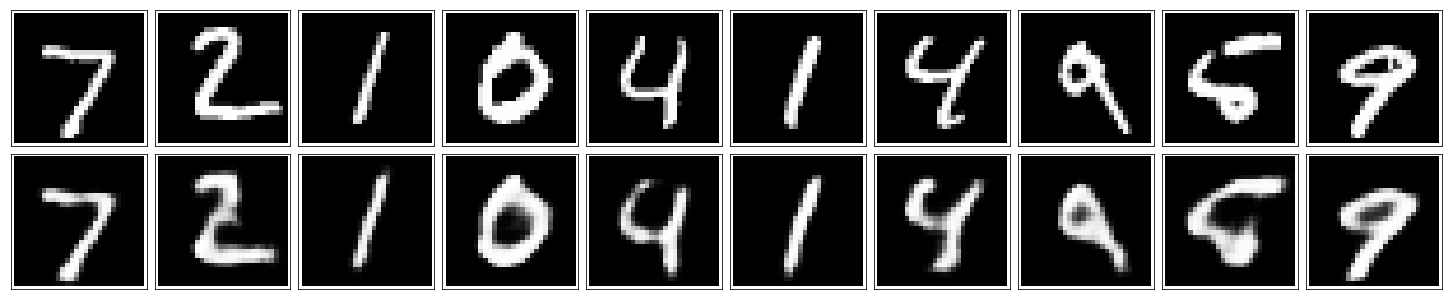

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [33]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [21]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = 
# Now 28x28x32
maxpool1 = 
# Now 14x14x32
conv2 = 
# Now 14x14x32
maxpool2 = 
# Now 7x7x32
conv3 = 
# Now 7x7x16
encoded = 
# Now 4x4x16

### Decoder
upsample1 = 
# Now 7x7x16
conv4 = 
# Now 7x7x16
upsample2 = 
# Now 14x14x16
conv5 = 
# Now 14x14x32
upsample3 = 
# Now 28x28x32
conv6 = 
# Now 28x28x32

logits = 
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded =

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = 

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [22]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

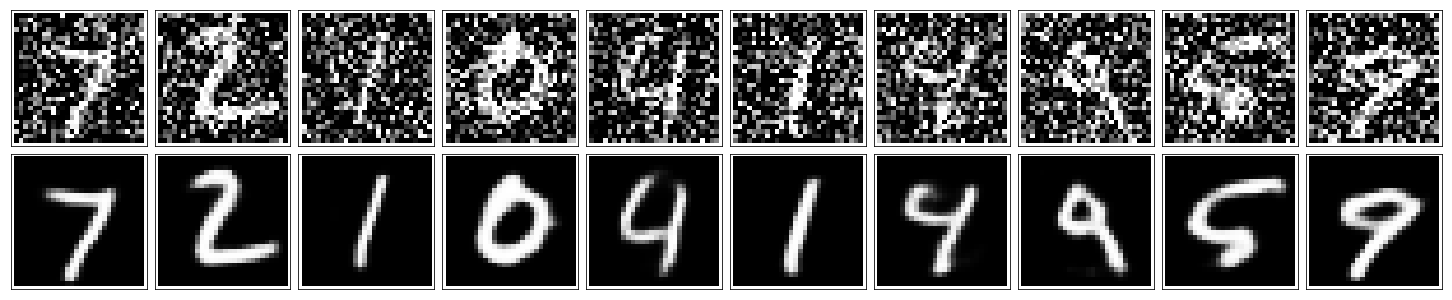

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)